# **CNN para la identificacion de Perros y Gatos**

In [22]:
!pip install tensorflow
!pip install keras-vis
!pip install tensorflow keras-vis
!pip install kaggle

In [23]:
!pip install tf-keras-vis
!pip install tf-keras-vis tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 4.2 MB/s eta 0:00:00


In [5]:
!kaggle datasets download -d jhe2918/cats-and-dogs-small

Dataset URL: https://www.kaggle.com/datasets/jhe2918/cats-and-dogs-small
License(s): unknown
 93% 81.0M/86.7M [00:00<00:00, 159MB/s]
100% 86.7M/86.7M [00:00<00:00, 138MB/s]


In [24]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns
import warnings
import os
import pickle
import zipfile
import shutil
from sklearn.model_selection import train_test_split

warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
pd.set_option('display.max_rows', 100)
pd.set_option('display.max_columns', 200)

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.layers import Dense, Input, Conv2D, MaxPooling2D, Flatten, Dropout
from tensorflow.keras.datasets import mnist
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import backend as K
from tensorflow.keras import activations
from tensorflow.keras import layers



# Utility Functions

In [3]:
def smooth_curve(points, factor=0.8):
    smoothed = []
    for point in points:
        if smoothed:
            previous = smoothed[-1]
            smoothed.append(previous * factor + point * (1 - factor))
        else:
            smoothed.append(point)
    return smoothed

def plot_compare(history, steps=-1):
    if steps < 0:
        steps = len(history.history['accuracy'])
    accuracy = smooth_curve(history.history['accuracy'][:steps])
    val_accuracy = smooth_curve(history.history['val_accuracy'][:steps])
    loss = smooth_curve(history.history['loss'][:steps])
    val_loss = smooth_curve(history.history['val_loss'][:steps])

    plt.figure(figsize=(6, 4))
    plt.plot(loss, c='#0c7cba', label='Train Loss')
    plt.plot(val_loss, c='#0f9d58', label='Val Loss')
    plt.xticks(range(0, len(loss), 5))
    plt.xlim(0, len(loss))
    plt.title('Train Loss: %.3f, Val Loss: %.3f' % (loss[-1], val_loss[-1]), fontsize=12)
    plt.legend()

    plt.figure(figsize=(6, 4))
    plt.plot(accuracy, c='#0c7cba', label='Train Acc')
    plt.plot(val_accuracy, c='#0f9d58', label='Val Acc')
    plt.xticks(range(0, len(accuracy), 5))
    plt.xlim(0, len(accuracy))
    plt.title('Train Accuracy: %.3f, Val Accuracy: %.3f' % (accuracy[-1], val_accuracy[-1]), fontsize=12)
    plt.legend()

def deprocess_image(x):
    # normalize tensor: center on 0., ensure std is 0.1
    x -= x.mean()
    x /= (x.std() + 1e-5)
    x *= 0.1

    # clip to [0, 1]
    x += 0.5
    x = np.clip(x, 0, 1)

    # convert to RGB array
    x *= 255
    x = np.clip(x, 0, 255).astype('uint8')
    return x

def save_history(history, fn):
    with open(fn, 'wb') as fw:
        pickle.dump(history.history, fw, protocol=2)

def load_history(fn):
    class Temp():
        pass
    history = Temp()
    with open(fn, 'rb') as fr:
        history.history = pickle.load(fr)
    return history

def jitter(img, amount=32):
    ox, oy = np.random.randint(-amount, amount+1, 2)
    return np.roll(np.roll(img, ox, -1), oy, -2), ox, oy

def reverse_jitter(img, ox, oy):
    return np.roll(np.roll(img, -ox, -1), -oy, -2)

def plot_image(img):
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.axis('off')

# Building a Convolutional Neural Network

## Model Definition

In [4]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model.add(MaxPooling2D((2, 2), name='maxpool_1'))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model.add(MaxPooling2D((2, 2), name='maxpool_2'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model.add(MaxPooling2D((2, 2), name='maxpool_3'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model.add(MaxPooling2D((2, 2), name='maxpool_4'))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu', name='dense_1'))
model.add(Dense(256, activation='relu', name='dense_2'))
model.add(Dense(1, activation='sigmoid', name='output'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

## Data Generator

In [57]:
base_dir = '/content/cats-and-dogs-small.zip'
zip_ref = zipfile.ZipFile(base_dir, 'r')
zip_ref.extractall('/content')
zip_ref.close()

In [60]:
# Directorios de origen y destino
extract_dir = '/content/catss_and_dogs_small'
source_dirs = ['cats', 'dogs']

def prepare_data(base_dir, categories):
    for category in categories:
        source_dir = os.path.join(base_dir, 'test', category)
        if not os.path.exists(source_dir):
            print(f"Directorio {source_dir} no encontrado. Verifica la estructura.")
            continue

        # Obtener y dividir imágenes
        images = os.listdir(source_dir)
        train_imgs, temp_imgs = train_test_split(images, test_size=0.3, random_state=42)
        val_imgs, test_imgs = train_test_split(temp_imgs, test_size=0.5, random_state=42)

        # Directorios destino
        splits = {'train': train_imgs, 'validation': val_imgs, 'test': test_imgs}
        for split, img_list in splits.items():
            target_dir = os.path.join(base_dir, split, category)
            os.makedirs(target_dir, exist_ok=True)
            for img in img_list:
                shutil.copy(os.path.join(source_dir, img), os.path.join(target_dir, img))

prepare_data(extract_dir, source_dirs)

#Generadores de datos
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_gen = datagen.flow_from_directory(os.path.join(extract_dir, 'train'), target_size=(150, 150), batch_size=20, class_mode='binary')
val_gen = datagen.flow_from_directory(os.path.join(extract_dir, 'validation'), target_size=(150, 150), batch_size=20, class_mode='binary')
test_gen = datagen.flow_from_directory(os.path.join(extract_dir, 'test'), target_size=(150, 150), batch_size=20, class_mode='binary')

## Training

In [8]:
history = model.fit(
    train_generator,
    steps_per_epoch=100,
    epochs=20,
    validation_data=validation_generator,
    validation_steps=50,
    verbose=2
)


Epoch 1/20
100/100 - 16s - 158ms/step - accuracy: 0.4950 - loss: 0.7125 - val_accuracy: 0.5110 - val_loss: 0.6930
Epoch 2/20
100/100 - 2s - 21ms/step - accuracy: 0.5057 - loss: 0.6933 - val_accuracy: 0.5067 - val_loss: 0.6927
Epoch 3/20
100/100 - 9s - 91ms/step - accuracy: 0.5315 - loss: 0.6910 - val_accuracy: 0.5520 - val_loss: 0.6852
Epoch 4/20
100/100 - 1s - 12ms/step - accuracy: 0.5457 - loss: 0.6874 - val_accuracy: 0.4400 - val_loss: 0.7120
Epoch 5/20
100/100 - 10s - 102ms/step - accuracy: 0.5245 - loss: 0.6923 - val_accuracy: 0.5500 - val_loss: 0.6659
Epoch 6/20
100/100 - 1s - 11ms/step - accuracy: 0.5629 - loss: 0.6766 - val_accuracy: 0.5733 - val_loss: 0.6629
Epoch 7/20
100/100 - 5s - 46ms/step - accuracy: 0.5675 - loss: 0.6706 - val_accuracy: 0.5740 - val_loss: 0.6569
Epoch 8/20
100/100 - 1s - 12ms/step - accuracy: 0.6000 - loss: 0.6655 - val_accuracy: 0.6000 - val_loss: 0.6448
Epoch 9/20
100/100 - 6s - 60ms/step - accuracy: 0.6105 - loss: 0.6540 - val_accuracy: 0.5900 - val_l

In [9]:
model.save('model.h5')
save_history(history, 'history.bin')

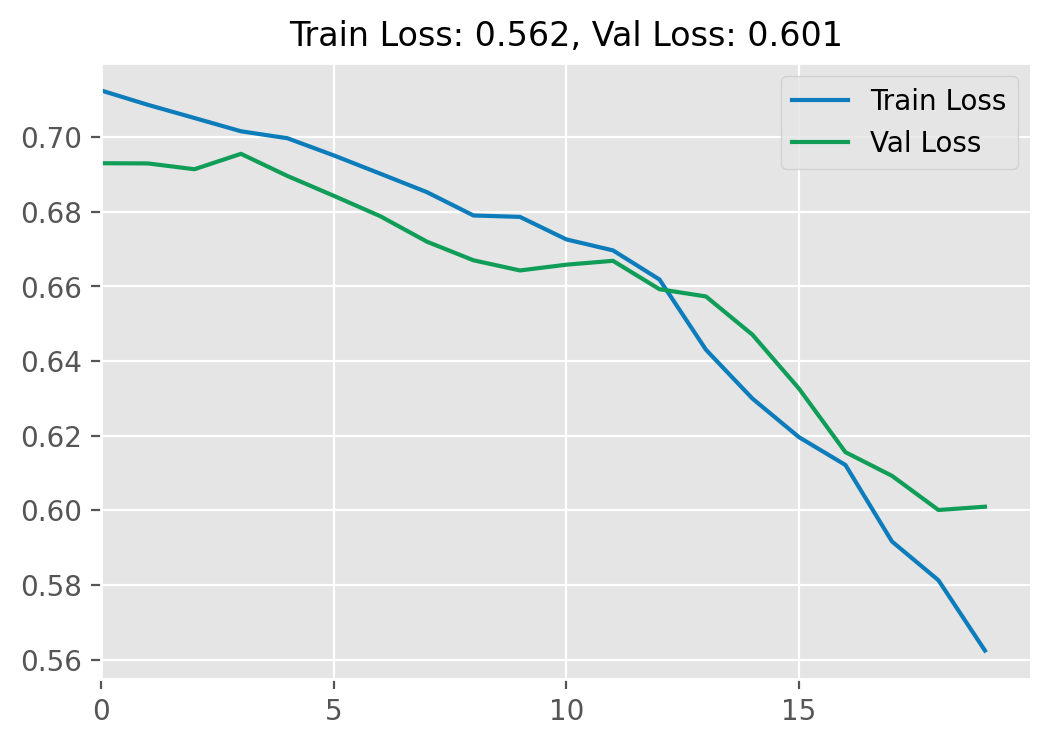

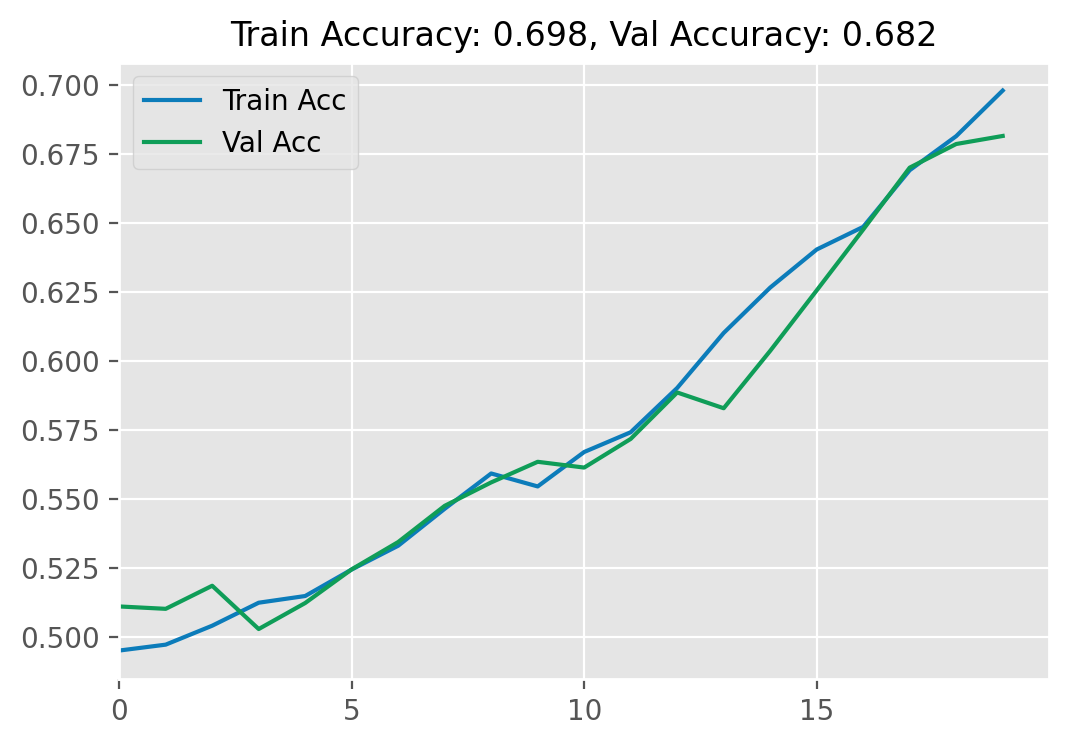

In [10]:
history = load_history('history.bin')
plot_compare(history)

## Data Augmentation

In [11]:
model_aug = Sequential()
model_aug.add(Conv2D(32, (3, 3), activation='relu', padding='same', name='conv_1',
                 input_shape=(150, 150, 3)))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_1'))
model_aug.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='conv_2'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_2'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_3'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_3'))
model_aug.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='conv_4'))
model_aug.add(MaxPooling2D((2, 2), name='maxpool_4'))
model_aug.add(Flatten())
model_aug.add(Dropout(0.5))
model_aug.add(Dense(512, activation='relu', name='dense_1'))
model_aug.add(Dense(256, activation='relu', name='dense_2'))
model_aug.add(Dense(1, activation='sigmoid', name='output'))

In [12]:
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [13]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,)

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator(rescale=1./255)

train_dir = os.path.join(extract_dir, '/content/cats_and_dogs_small/train')
validation_dir = os.path.join(extract_dir, '/content/cats_and_dogs_small/validation')

train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(150, 150),
        batch_size=32,
        class_mode='binary')

# early_stop = EarlyStopping(monitor='val_loss', patience=6, verbose=1)
history_aug = model_aug.fit(train_generator, steps_per_epoch=100, epochs=60,
                                      validation_data=validation_generator, validation_steps=50, verbose=1)

Found 2700 images belonging to 2 classes.
Found 1150 images belonging to 2 classes.
Epoch 1/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 250ms/step - accuracy: 0.5086 - loss: 0.7120 - val_accuracy: 0.5000 - val_loss: 0.7083
Epoch 2/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 33s 205ms/step - accuracy: 0.5007 - loss: 0.6955 - val_accuracy: 0.5461 - val_loss: 0.6866
Epoch 3/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.5186 - loss: 0.6953 - val_accuracy: 0.5000 - val_loss: 0.7114
Epoch 4/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 19s 182ms/step - accuracy: 0.5260 - loss: 0.6962 - val_accuracy: 0.5000 - val_loss: 0.6931
Epoch 5/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 22s 205ms/step - accuracy: 0.4970 - loss: 0.6922 - val_accuracy: 0.5722 - val_loss: 0.6697
Epoch 6/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 40s 188ms/step - accuracy: 0.5184 - loss: 0.6886 - val_accuracy: 0.5000 - val_loss: 0.6929
Epoch 7/60
100/100 ━━━━━━━━━━━━━━━━━━━━ 41s 195ms/step - accuracy: 0.5071 - loss: 0.6933 - val_accuracy: 0.5000 - val_loss: 0.6932

In [14]:
model_aug.save('model_aug.h5')
save_history(history_aug, 'history_aug.bin')

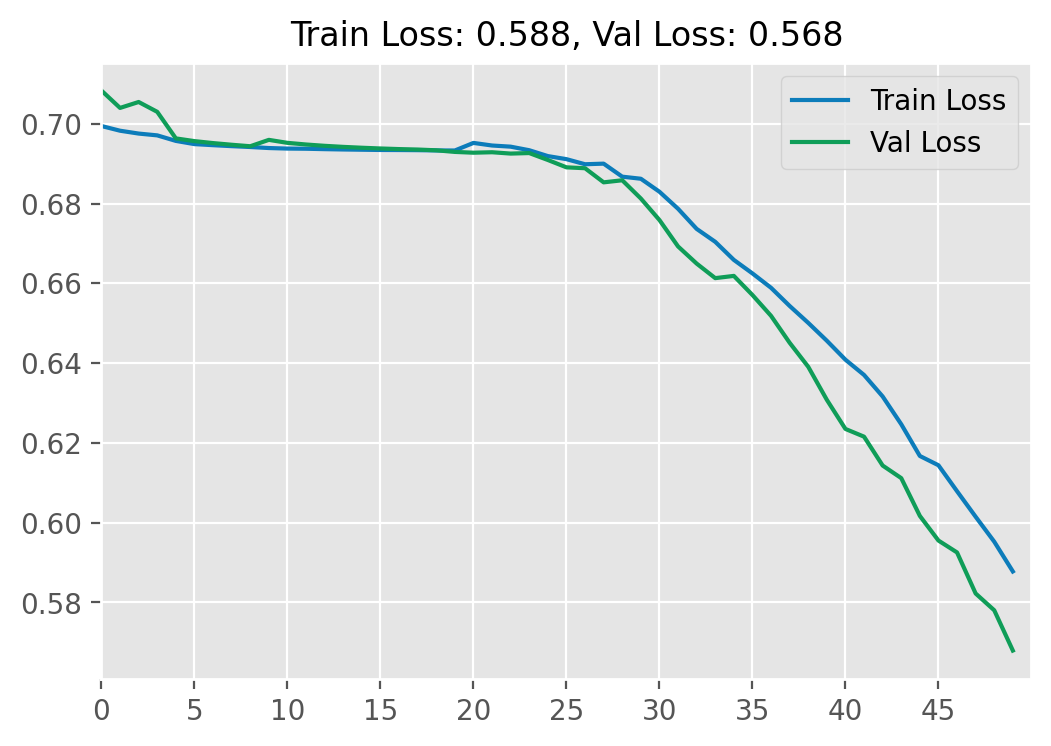

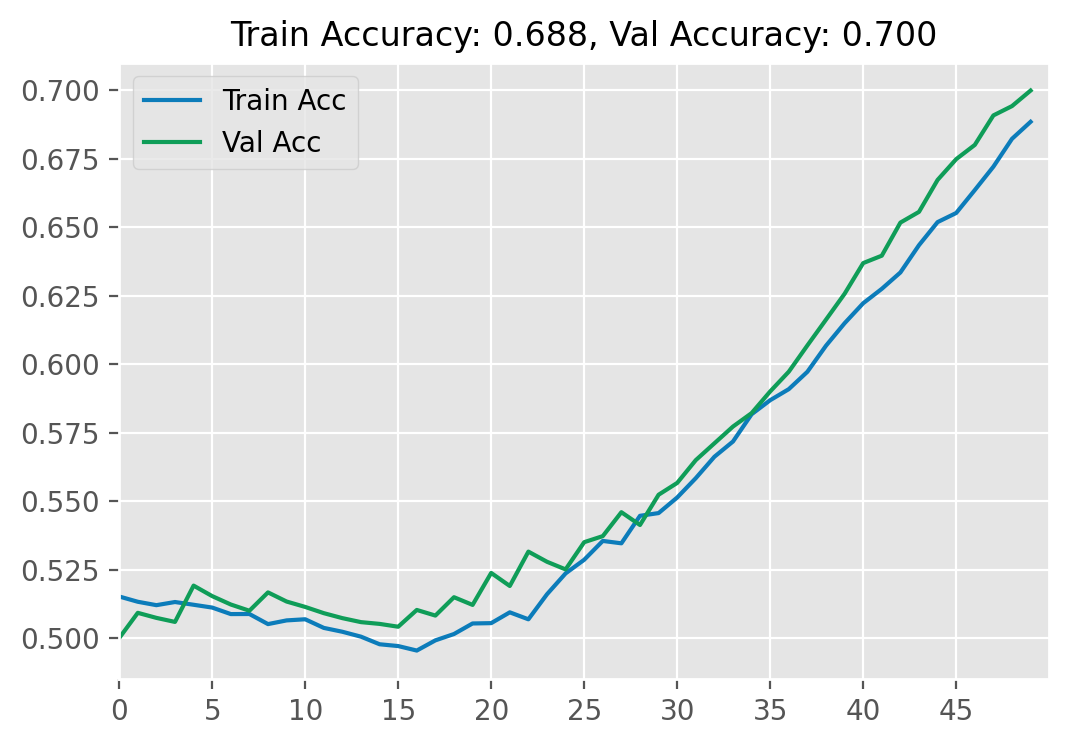

In [15]:
history_aug = load_history('history_aug.bin')
plot_compare(history_aug, steps=50)

# Visualizing Feature Maps

In [17]:
img_path = '/content/cats_and_dogs_small/train/cats/cat.59.jpg'

img = image.load_img(img_path, target_size=(150, 150))
img_tensor = image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
img_tensor /= 255.
print(img_tensor.shape)

(1, 150, 150, 3)


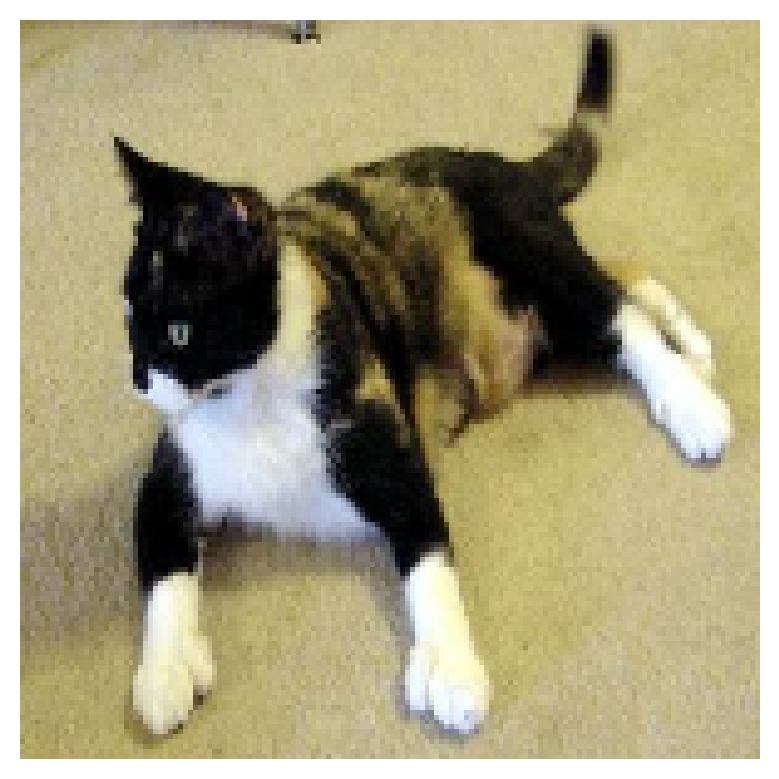

In [18]:
plt.imshow(img_tensor[0])
plt.axis('off')
plt.show()

In [19]:
vgg = VGG16(weights='imagenet', include_top=False)
vgg.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)           │ (None, None, None, 3)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, None, None, 64)      │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, None, None, 64)      │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, None, None, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, None, None, 128)     │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, None, None, 128)     │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, None, None, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, None, None, 256)     │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, None, None, 256)     │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, None, None, 256)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, None, None, 512)     │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, None, None, 512)     │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, None, None, 512)     │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


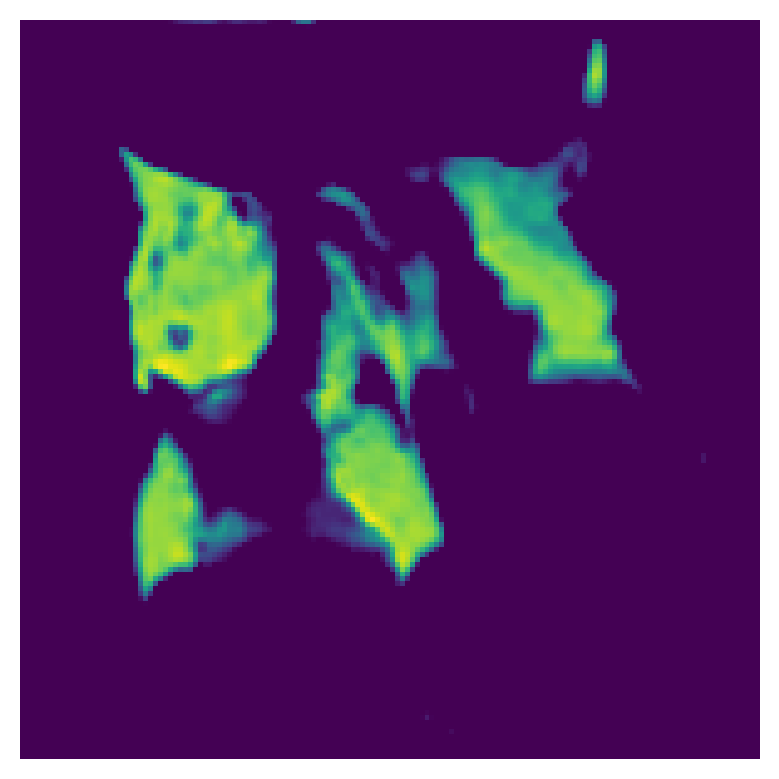

In [20]:
# Extracts the outputs of the top 8 layers:
layer_outputs = [layer.output for layer in vgg.layers if 'conv1' in layer.name]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

first_layer_activation = intermediate_activations[0]

plt.imshow(first_layer_activation[0, :, :, 19], cmap='viridis')
plt.axis('off')
plt.show()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step


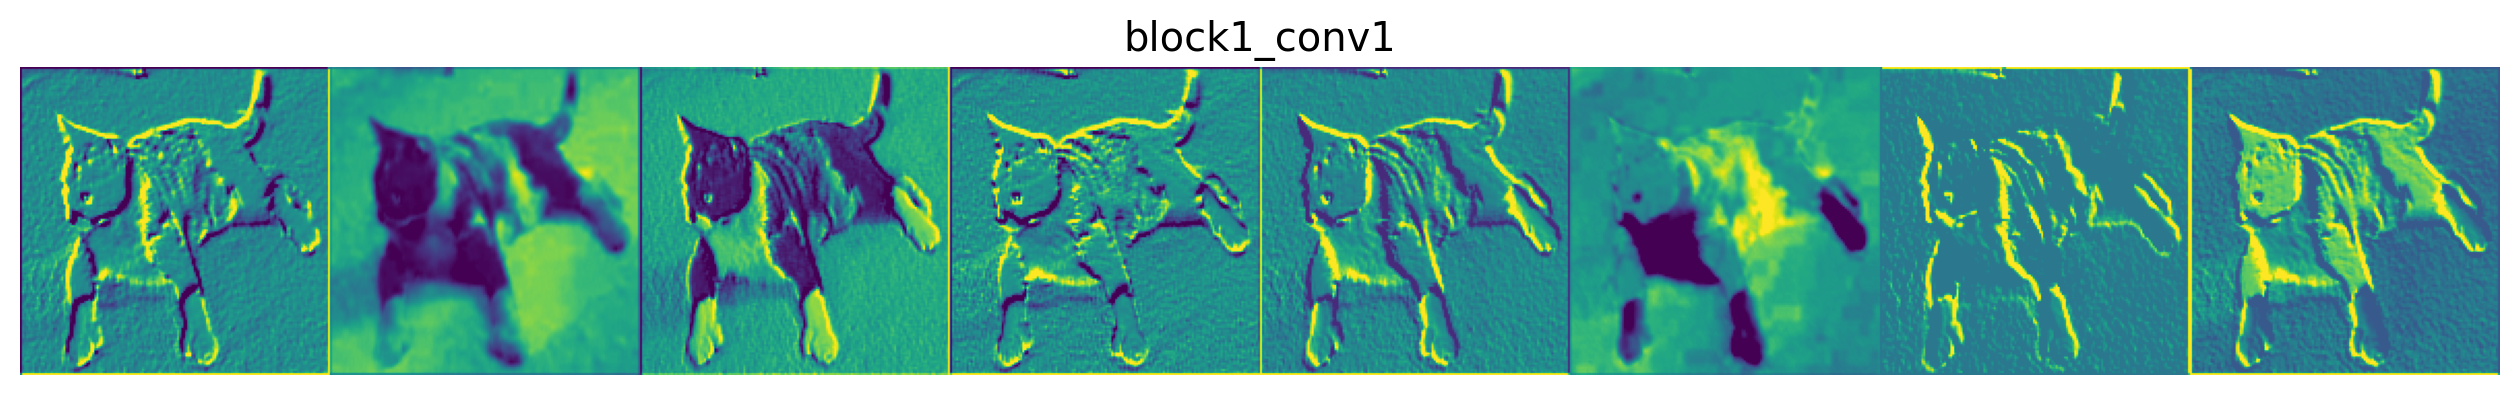

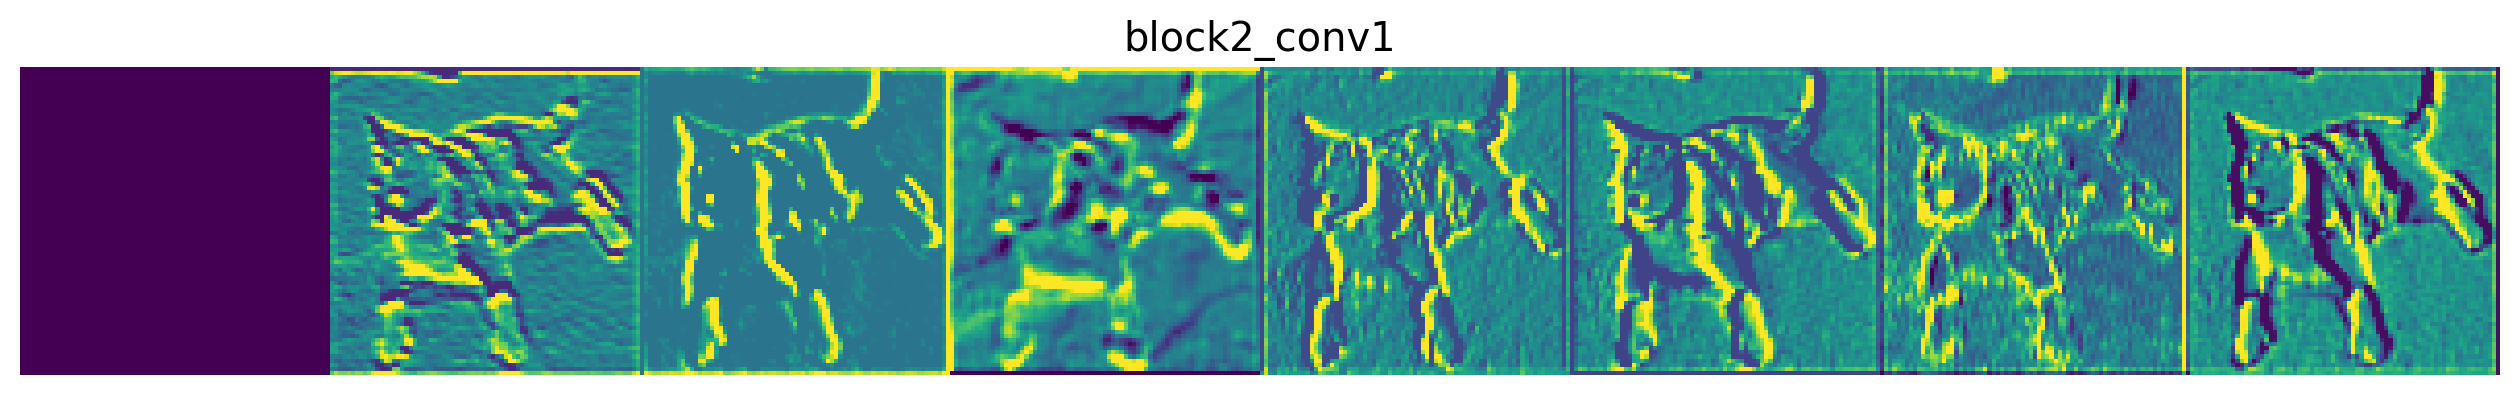

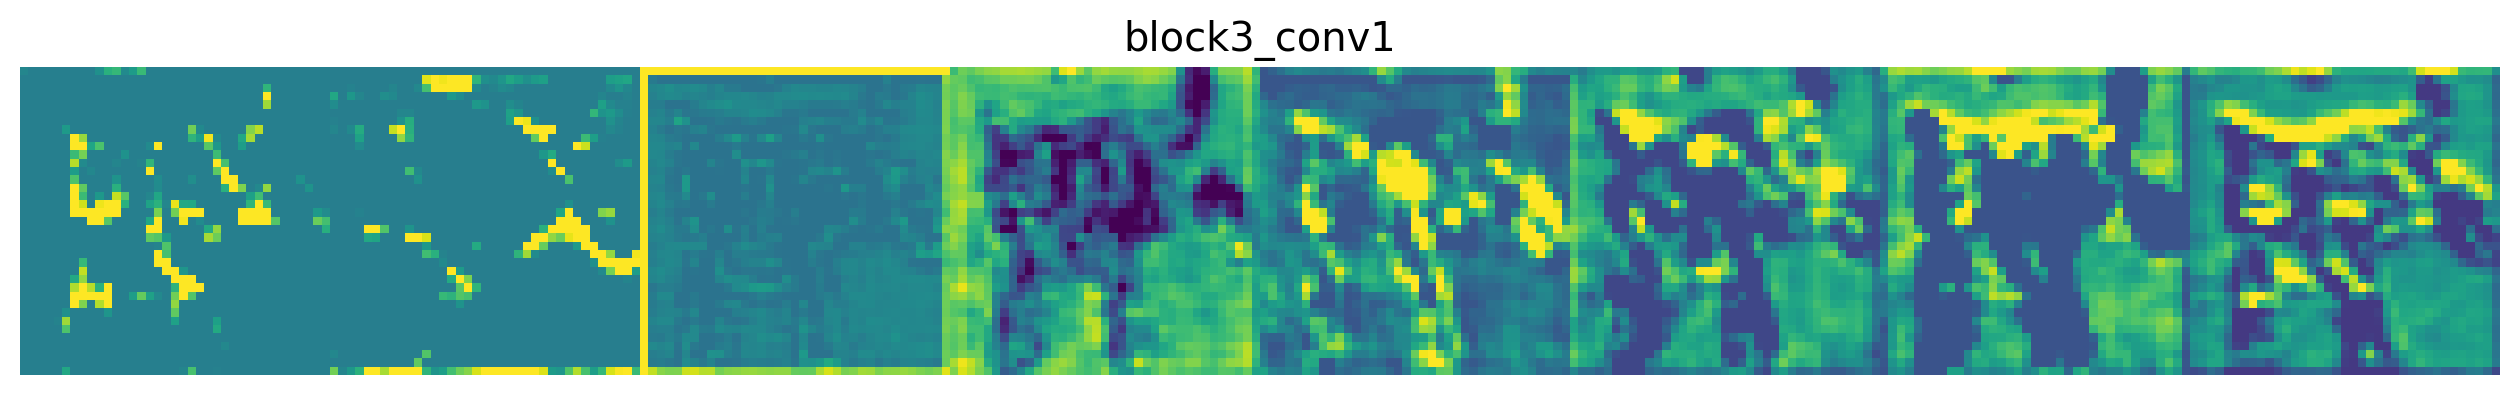

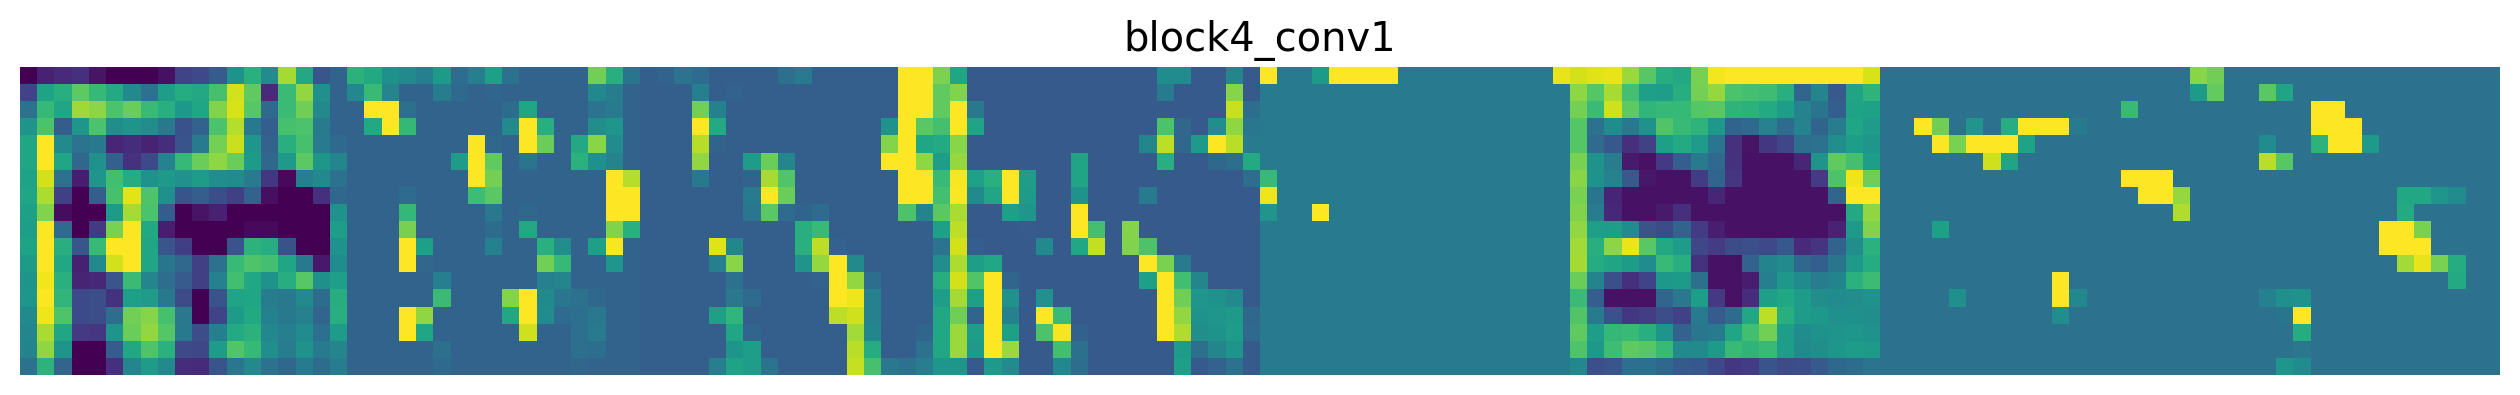

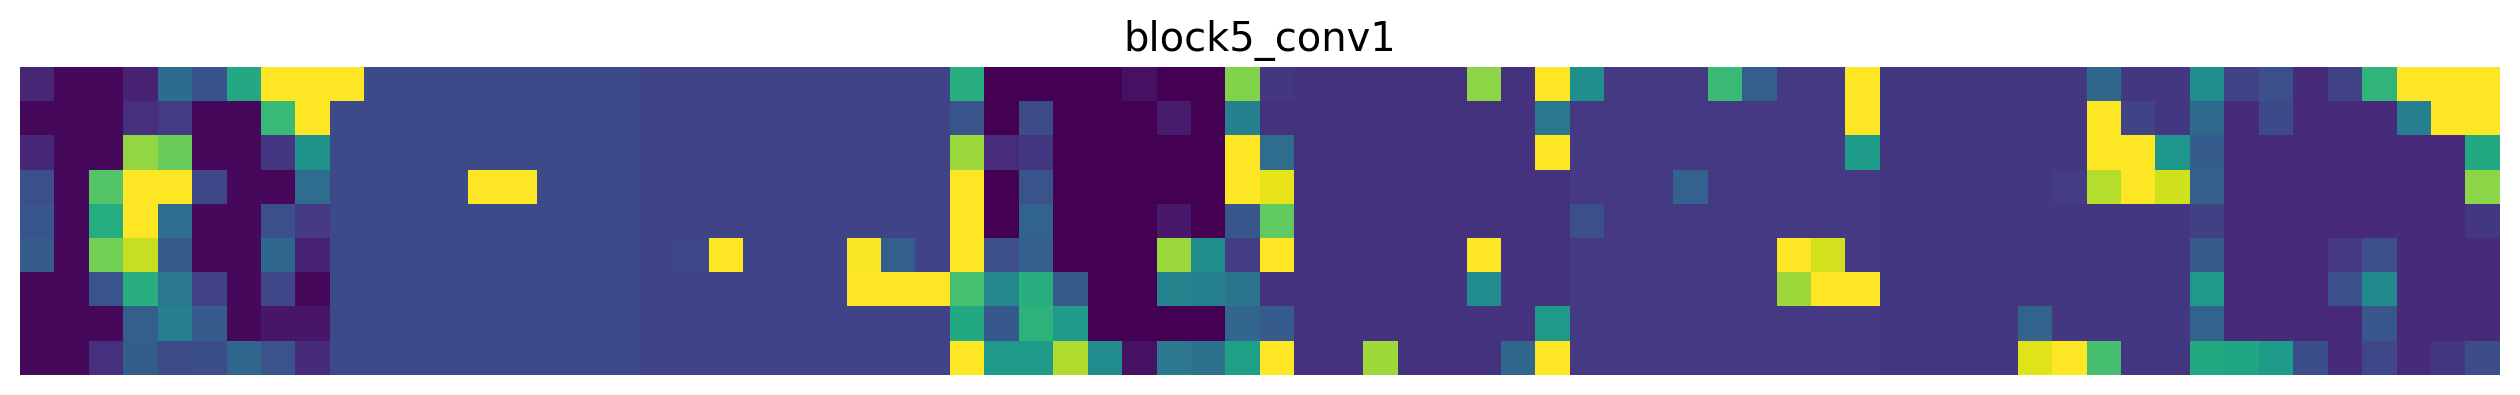

In [21]:
layer_names = ['block1_conv1', 'block2_conv1', 'block3_conv1', 'block4_conv1', 'block5_conv1']

layer_outputs = [layer.output for layer in vgg.layers if layer.name in layer_names]
activation_model = Model(inputs=vgg.input, outputs=layer_outputs)
intermediate_activations = activation_model.predict(img_tensor)

images_per_row = 8
max_images = 8
# Now let's display our feature maps
for layer_name, layer_activation in zip(layer_names, intermediate_activations):
    # This is the number of features in the feature map
    n_features = layer_activation.shape[-1]
    n_features = min(n_features, max_images)

    # The feature map has shape (1, size, size, n_features)
    size = layer_activation.shape[1]

    # We will tile the activation channels in this matrix
    n_cols = n_features // images_per_row
    display_grid = np.zeros((size * n_cols, images_per_row * size))

    # We'll tile each filter into this big horizontal grid
    for col in range(n_cols):
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            # Post-process the feature to make it visually palatable
            channel_image -= channel_image.mean()
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size,
                         row * size : (row + 1) * size] = channel_image

    # Display the grid
    scale = 2. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.axis('off')
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

plt.show()

# Dense Layer Visualization

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.applications.vgg16 import VGG16, decode_predictions
from tensorflow.keras.preprocessing import image
from tf_keras_vis.utils.model_modifiers import ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D

categories = '''
rabbit 330
crocodile 49
starfish 327
husky 248
goldfish 1
bridge 839
balloon 417
tennis ball 852
gondola 576
dumbbell 543
hammer 587
lamp 846
'''

def load_vgg16_model():
    """Carga el modelo VGG16 preentrenado con pesos de ImageNet."""
    model = VGG16(weights='imagenet', include_top=True)
    return model

In [31]:
def generate_initial_images(model, categories, steps=100):
    replace2linear = ReplaceToLinear()
    activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

    initial_images = []
    tuples = []

    for line in categories.strip().split('\n'):
        name, idx = line.rsplit(' ', 1)
        idx = int(idx)
        score = CategoricalScore([idx])

        # Generar la imagen inicial
        img = activation_maximization(score, steps=steps)
        img_np = img[0].numpy()

        # Normalizar a [0, 1] si es necesario
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) if img_np.dtype.kind == 'f' else img_np

        # Guardar la imagen en disco
        img_path = f'./{name}_{idx}_initial.png'
        plt.imsave(img_path, img_np, format='png')
        initial_images.append(img_path)
        tuples.append((name, idx))

    return initial_images, tuples

In [32]:
def generate_final_images(model, tuples, initial_images, steps=400):
    replace2linear = ReplaceToLinear()
    activation_maximization = ActivationMaximization(model, model_modifier=replace2linear)

    image_paths = []

    for i, (name, idx) in enumerate(tuples):
        score = CategoricalScore([idx])

        # Cargar la imagen inicial desde disco
        img_np = plt.imread(initial_images[i])

        # Generar la imagen final usando modificadores y regularizadores
        img = activation_maximization(
            score, steps=steps,
            input_modifiers=[Jitter(16), Rotate2D(degree=0.15)],
            regularizers=[TotalVariation2D(weight=5)]
        )
        img_np = img[0].numpy()

        # Normalizar a [0, 1] si es necesario
        img_np = (img_np - img_np.min()) / (img_np.max() - img_np.min()) if img_np.dtype.kind == 'f' else img_np

        # Convertir a uint8 para asegurar que esté en el rango 0-255
        img_np = np.uint8(img_np * 255)

        # Guardar la imagen final en disco
        img_path = f'./{name}_{idx}_final.png'
        plt.imsave(img_path, img_np, format='png')
        image_paths.append(img_path)

    return image_paths

In [33]:
def plot_image_collage(image_paths, cols=4, rows=3):
    #Crea un collage con las imágenes generadas.
    fig, axes = plt.subplots(rows, cols, figsize=(20, 15))

    for i, img_path in enumerate(image_paths):
        img_np = plt.imread(img_path)
        ax = axes[i // cols, i % cols]
        ax.imshow(img_np)
        ax.axis('off')

    # Ocultar los ejes vacíos
    for j in range(i + 1, rows * cols):
        axes[j // cols, j % cols].axis('off')

    plt.show()

In [34]:
def evaluate_image(model, img_path, true_label=None):

    # Cargar la imagen y convertirla al formato requerido por VGG16
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = tf.keras.applications.vgg16.preprocess_input(img_array)

    # Hacer la predicción
    predictions = model.predict(img_array)
    decoded_predictions = decode_predictions(predictions, top=3)[0]

    # Mostrar la imagen
    plt.imshow(image.load_img(img_path, target_size=(224, 224)))
    plt.axis('off')
    plt.show()

    # Mostrar las predicciones
    for pred in decoded_predictions:
        print(f"Predicción: {pred[1]}, Probabilidad: {pred[2]:.4f}")

    # Verificar si el modelo fue eficiente
    if true_label:
        pred_label = decoded_predictions[0][1]  # Clase predicha
        is_correct = pred_label.lower() == true_label.lower()
        print(f"¿Predicción correcta?: {'Sí' if is_correct else 'No'}")

In [35]:
model = load_vgg16_model()

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 13s 0us/step


In [36]:
initial_images, tuples = generate_initial_images(model, categories)

In [37]:
final_images = generate_final_images(model, tuples, initial_images)

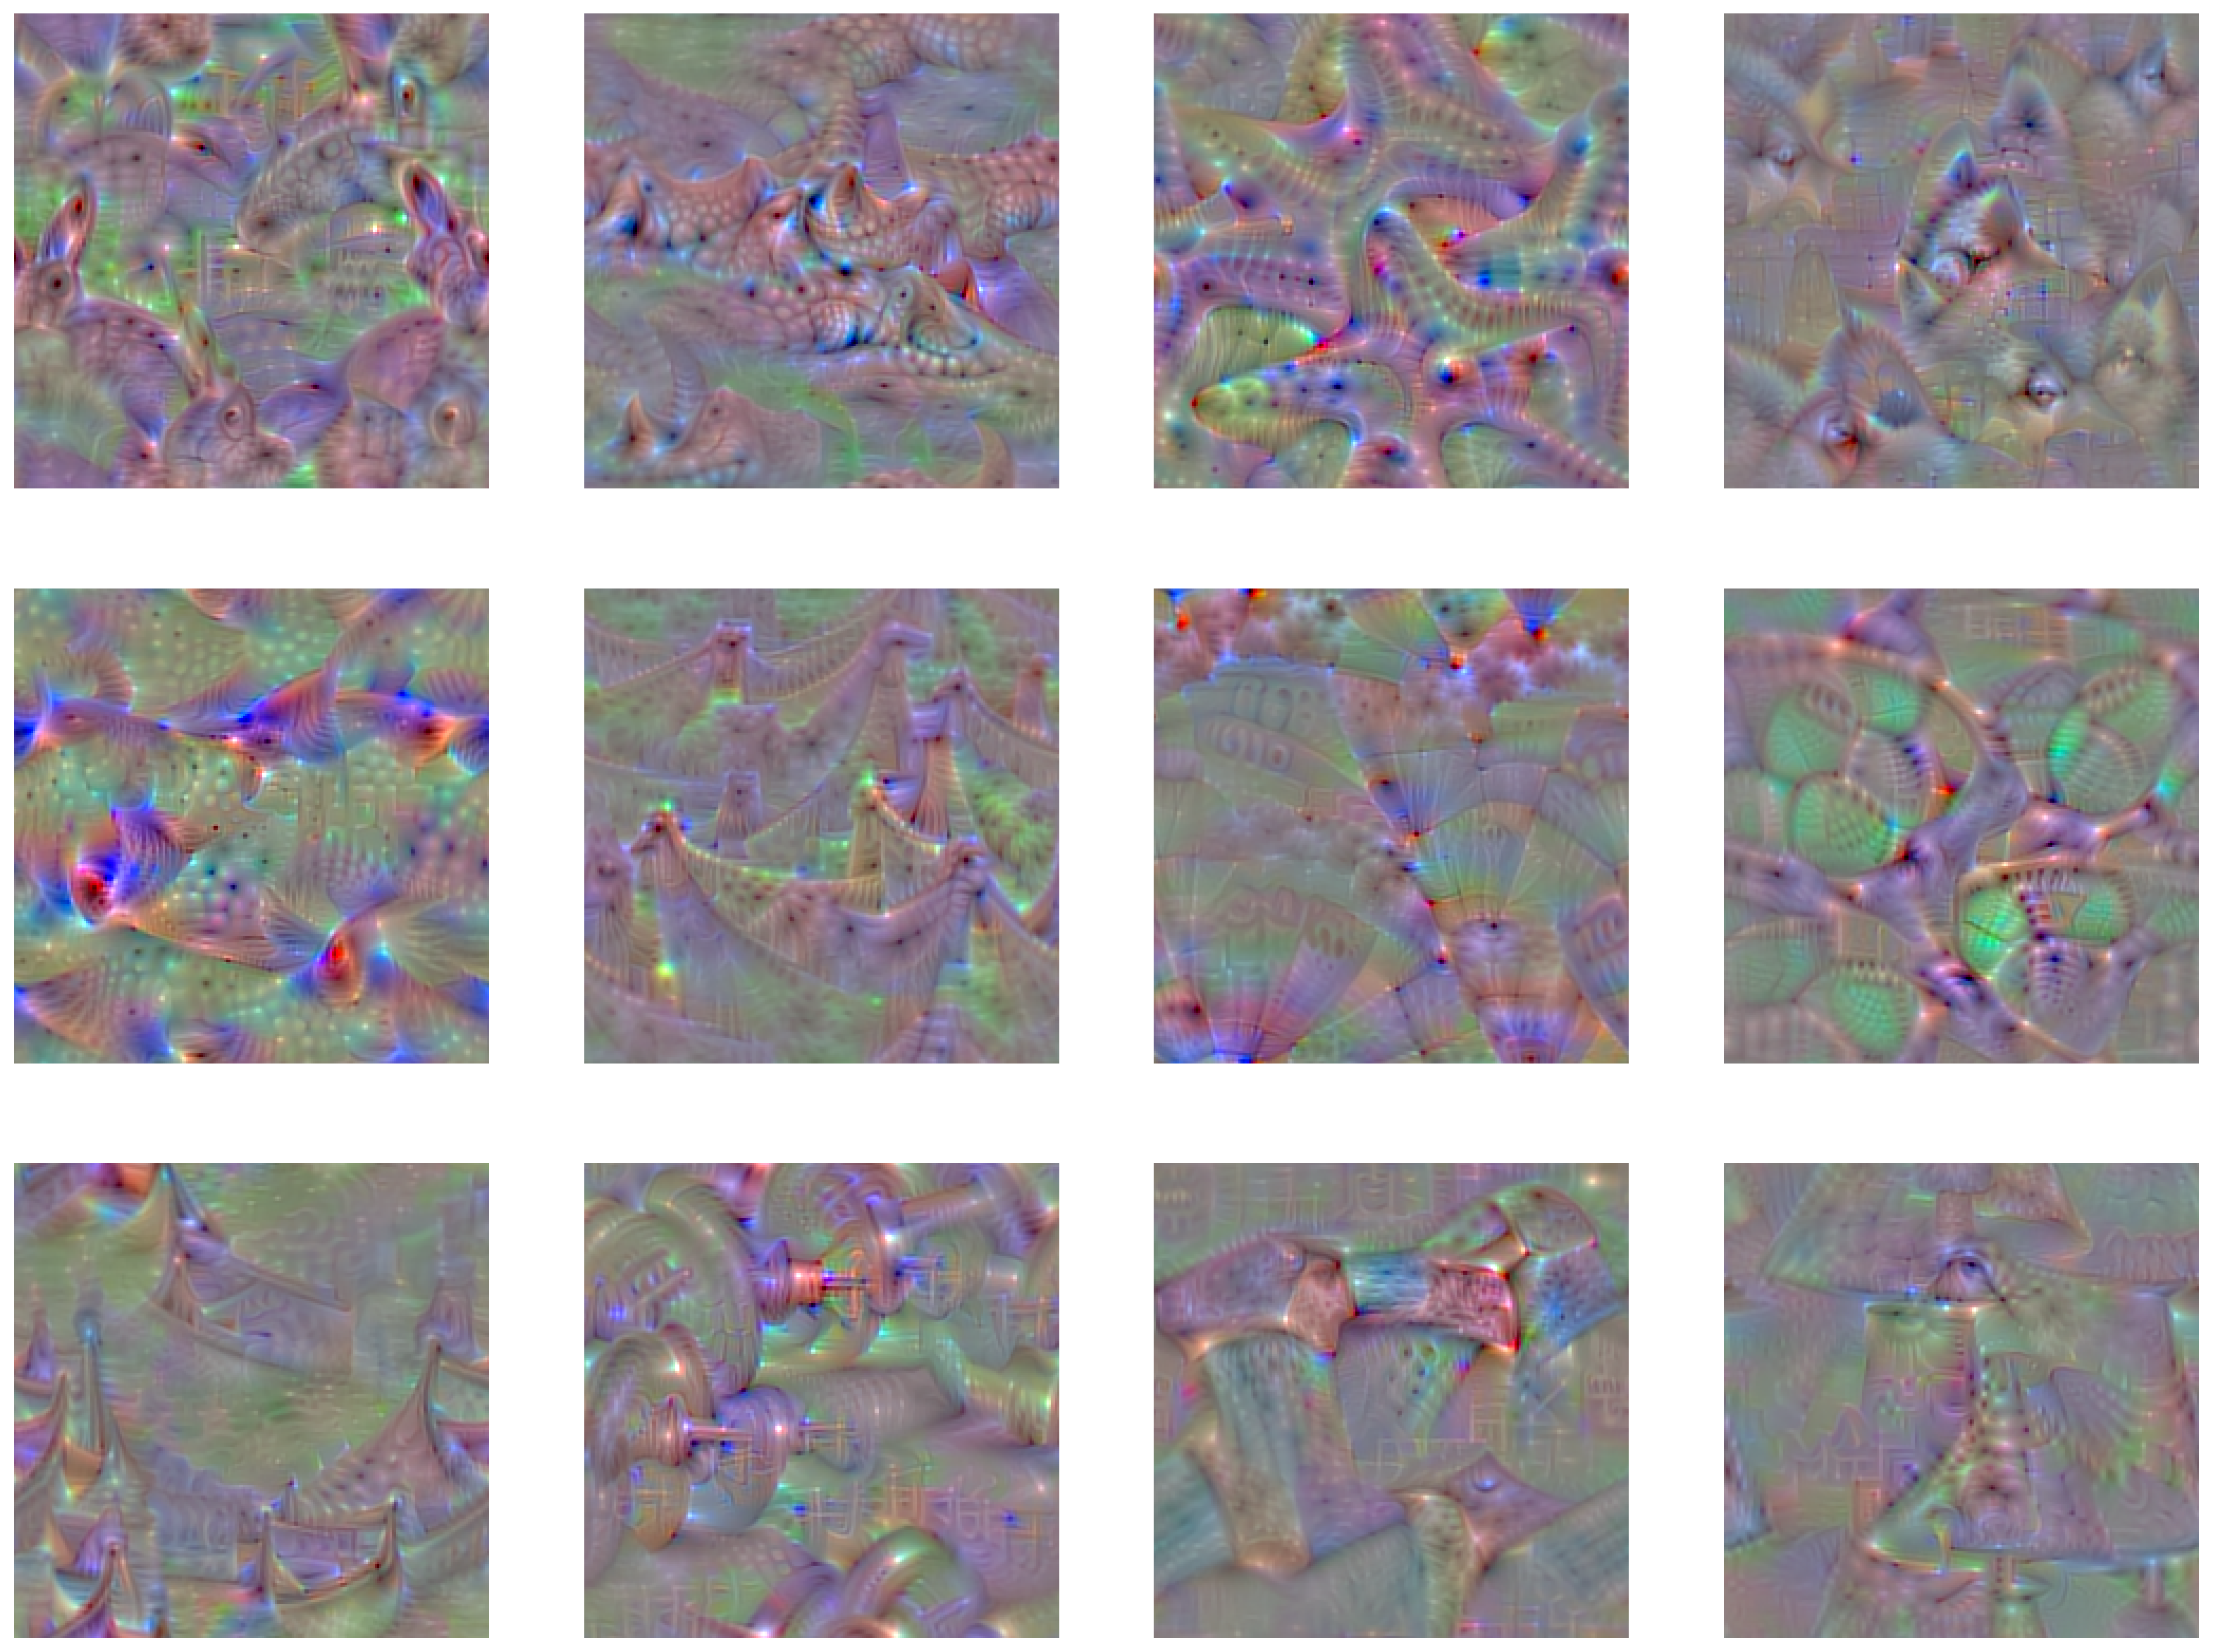

In [38]:
plot_image_collage(final_images)

# **Comprobación**

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step


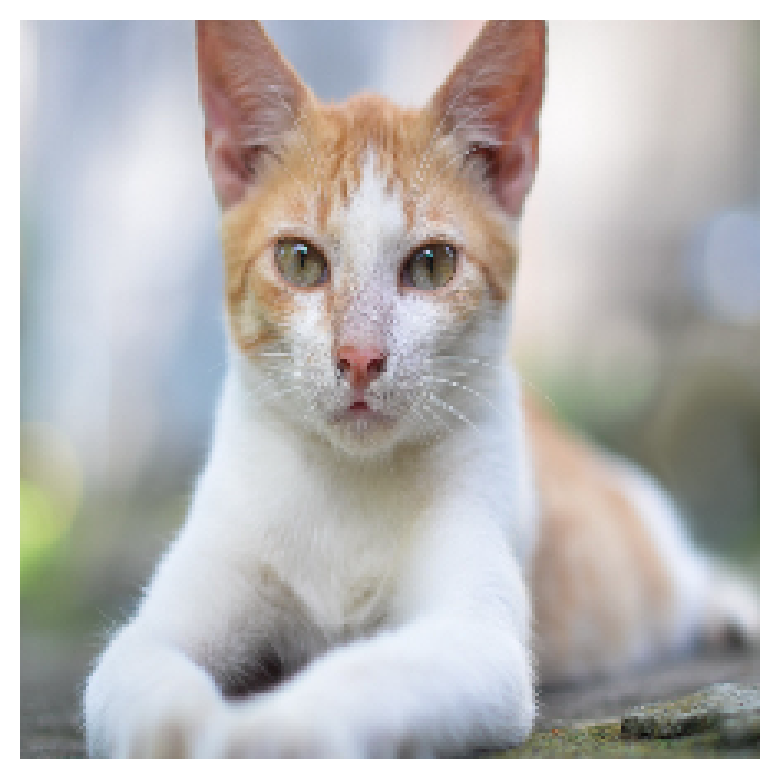

Predicción: Ibizan_hound, Probabilidad: 0.3322
Predicción: Egyptian_cat, Probabilidad: 0.3211
Predicción: tiger_cat, Probabilidad: 0.0744


In [46]:

img_path = '/content/gato.png'

evaluate_image(model, img_path)